# AO Telemetry
##### CFAO Fall Retreat 2020
This notebook will give an introduction to the use of Keck AO telemetry data and raise some outstanding questions we have about AO performance and telemetry recording. All the data for this notebook can be found in the shared folder *[2020_cfao_retreat_public](https://drive.google.com/drive/folders/1e1xflCLi-uWbnmz0iEZuT58W8DRH5dq_)* -> *[hackathon](https://drive.google.com/drive/folders/1z8ShdhZyKj7FPCPrM93VPxnfIpLPVKcR)*. The telemetry files are stored in *[Telemetry_Files.zip](https://drive.google.com/file/d/11H78G3cQBufbHbuzhfMyx0T8mtrZBDVs/view?usp=sharing)* and the combined nirc2+weather+seeing+telemetry dataset can be found in *[keck_ao_metadata.zip](https://drive.google.com/file/d/1TWQu0fm0kS3z-i1q37pL7H8prfQFUs_M/view?usp=sharing)*. To use this notebook, unzip these files in a directory of your choice and change the relevant paths in the preamble below. More information and background on AO telemetry files can be found in last year's hackathon file: *[AO Telemetry 2019.ipynb](https://drive.google.com/file/d/1meT-YPRXwapmZd1paua3-_ltX1KSkU-w/view?usp=sharing)*.

In [1]:
### Preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from matplotlib import cm
import matplotlib as mpl
from astropy.time import Time

from CFAOutils import (clean_data, plot_array, corner_plot,
                       split_centroids, combine_centroids)

### Path to telemetry files [EDIT THIS]
telem_dir = './data/Telemetry_Files/'

# Sub-aperture maps
centroid_map = telem_dir+"sub_ap_map.txt"
resid_map = telem_dir+"act.txt"

# Combined Data Path [EDIT THIS]
data_dir = "./"
# CSV with NIRC2, weather, seeing, and telemetry data combined
data_file = data_dir+"keck_ao_metadata.dat"

# Columns to use from the combined data (feel free to change)
usecols = ['mjd', 'dec_year', 'telem_file', 'rms_telemetry', 'rms_std_telemetry',
           'rms_img_strehl', 'lb_rms_hdr', 'strehl', 'fwhm']

# Limits for good data
clean_features = {
    'strehl': (0, np.inf),
    'fwhm': (0, 150),
}

In [2]:
mpl.rcParams['font.size']=16
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)

##### Combined Dataset
This dataset combines 14 years of Galactic Center image data with seeing, weather, and telemetry data from the same observing nights. Data descriptions can be found in the table below:
![image](https://scontent-atl3-1.xx.fbcdn.net/v/t1.0-9/123168793_10217839290198500_2309566273105995815_o.jpg?_nc_cat=107&ccb=2&_nc_sid=730e14&_nc_ohc=FLIy1AZZhnMAX_eK5go&_nc_ht=scontent-atl3-1.xx&oh=d052202cc31937173dd813819401fdc1&oe=5FC05045)

In [3]:
# Read combined dataset
data = pd.read_csv(data_file)
data.columns = [x.lower() for x in data.columns]
data = data.rename(columns={"rms_mean": "rms_telemetry", "rms_std": "rms_std_telemetry",
                           "rms_err": "rms_img_strehl", "lgrmswf": "lb_rms_hdr"}) # Fix rms mix-ups
year = Time(data.mjd, format='mjd').decimalyear # Add decimal year column
data['dec_year'] = year
data.columns

Index(['file', 'strehl', 'rms_img_strehl', 'fwhm', 'mjd', 'epoch', 'airmass',
       'itime', 'coadds', 'fwiname', 'az', 'dmgain', 'dtgain', 'xref', 'yref',
       'xstrehl', 'ystrehl', 'wsfrrt', 'aolbfwhm', 'lsamppwr', 'lb_rms_hdr',
       'aoaoamed', 'tubetemp', 'telem_file', 'telem_mjd', 'rms_telemetry',
       'rms_std_telemetry', 'mass_mjd', 'dimm_mjd', 'masspro_mjd', 'cfht_mjd',
       'mass', 'dimm', 'masspro_half', 'masspro_1', 'masspro_2', 'masspro_4',
       'masspro_8', 'masspro_16', 'masspro', 'wind_speed', 'wind_direction',
       'temperature', 'relative_humidity', 'pressure', 'dec_year'],
      dtype='object')

In [4]:
# Clean data and select relevant telemetry columns
data = data[usecols]
data = clean_data(data, feature_limits=clean_features, dropna=True)
print(data.shape)
list(data.columns)

(1196, 10)


['index',
 'mjd',
 'dec_year',
 'telem_file',
 'rms_telemetry',
 'rms_std_telemetry',
 'rms_img_strehl',
 'lb_rms_hdr',
 'strehl',
 'fwhm']

### NIRC2 and telemetry file mismatch
The RMS Wavefront Residual value is recorded in each telemetry over all timestamps, and this can also be calculated from the image Strehl using [Marechal's approximation](https://en.wikipedia.org/wiki/Strehl_ratio). The NIRC2 header records the LBWFS residual as a keyword, giving us a third measurement to compare. These values should correlate fairly strongly, but, as we can see from this plot, the mean telemetry residuals don't seem to be correlated at all with the Strehl or the LBWFS residuals. We are currently investigating potential causes for this.

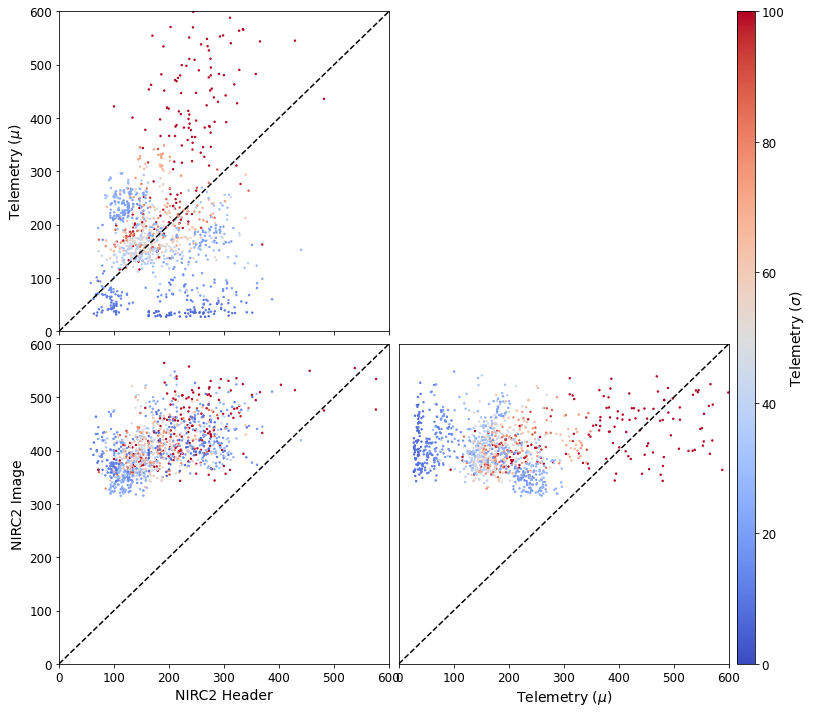

In [5]:
rmswf_data = data[['lb_rms_hdr', 'rms_telemetry', 'rms_img_strehl', 'rms_std_telemetry']]
# Set plotting limits
limits = {
    'lb_rms_hdr': [0, 600],
    'rms_img_strehl': [0, 600],
    'rms_telemetry': [0, 600],
    'rms_std_telemetry': [0, 100],
}
labels = ["NIRC2 Header", r"Telemetry ($\mu$)", "NIRC2 Image", r"Telemetry ($\sigma$)"]
fig, ax = corner_plot(rmswf_data, labels=labels, limits=limits, c_var='rms_std_telemetry')
plt.show()

### Telemetry Files
We have chosen a set of six telemetry files to use as potential examples, three with unusually high RMS Residuals and three without. Scipy's *readsav* function returns an **Attribute Dictionary**, which is functionally equivalent to a standard Python dictionary except that its elements can be accessed using either dot notation or brackets.

In [6]:
telem_files = {
    '20140703_bad': telem_dir+'n0199_fullLGS_trs.sav',
    '20160503_bad': telem_dir+'n0209_fullLGS_trs.sav',
    '20170727_bad': telem_dir+'n0640_LGS_trs.sav',
    '20140704_good': telem_dir+'n0160_fullLGS_trs.sav',
    '20160517_good': telem_dir+'n0058_fullLGS_trs.sav',
    '20170718_good': telem_dir+'n0108_LGS_trs.sav',
}

good_example = readsav(telem_files['20170718_good'])
bad_example = readsav(telem_files['20170727_bad'])

##### Telemetry fields
Each telemetry file has a series of timestamps (in 10s of ns from Jan 01, 1970), with arrays of measurements corresponding to each. Some telemetry files have headers with more information on the system. Data structure A holds WFS data while data structure B holds STRAP Tip/Tilt data. Further explanations of these files can be found in [KAON 1165](https://drive.google.com/file/d/1llk_1P3Hc1gztCzlKXLPhTXe7aKs3elS/view?usp=sharing) or [AO Telemetry 2019](https://drive.google.com/file/d/1meT-YPRXwapmZd1paua3-_ltX1KSkU-w/view?usp=sharing).

In [7]:
print("Dictionary Keys:\n", list(good_example.keys()))
print("\nData Structure A:")
good_example.a.dtype.fields

Dictionary Keys:
 ['a', 'b', 'uid', 'cid', 'nrec', 'rx', 'cent_origin', 'dm_origin', 'dtt_offset', 'tstamp_num', 'tstamp_str_start', 'cent_g', 'dm_servo', 'dt_servo', 'apd_imat', 'apd_sky_back', 'apd_threshold', 'header']

Data Structure A:


mappingproxy({'CONF_ID': (dtype('O'), 0, 'conf_id'),
              'conf_id': (dtype('O'), 0, 'conf_id'),
              'TIMESTAMP': (dtype('O'), 8, 'timestamp'),
              'timestamp': (dtype('O'), 8, 'timestamp'),
              'SUBAPINTENSITY': (dtype('O'), 16, 'subapintensity'),
              'subapintensity': (dtype('O'), 16, 'subapintensity'),
              'OFFSETCENTROID': (dtype('O'), 24, 'offsetcentroid'),
              'offsetcentroid': (dtype('O'), 24, 'offsetcentroid'),
              'RESIDUALWAVEFRONT': (dtype('O'), 32, 'residualwavefront'),
              'residualwavefront': (dtype('O'), 32, 'residualwavefront'),
              'DMCOMMAND': (dtype('O'), 40, 'dmcommand'),
              'dmcommand': (dtype('O'), 40, 'dmcommand'),
              'DMCOMMANDSCLIPPED': (dtype('O'), 48, 'dmcommandsclipped'),
              'dmcommandsclipped': (dtype('O'), 48, 'dmcommandsclipped'),
              'RESIDUALRMS': (dtype('O'), 56, 'residualrms'),
              'residualrms': (dtyp

### High RMS Wavefront Residuals
There are several telemetry files in our dataset that have very high RMS Wavefront Residuals, often for periods of several seconds, as shown below:

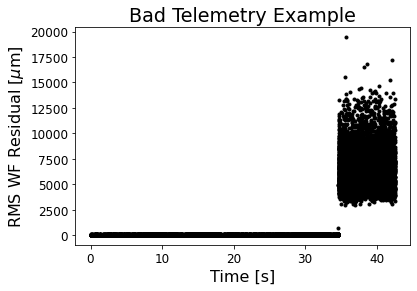

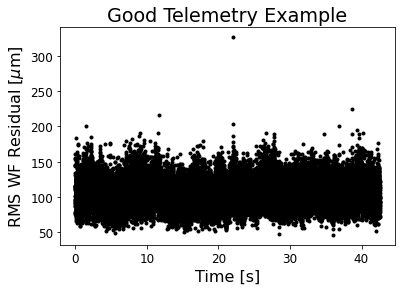

In [8]:
times = (bad_example.a.timestamp[0]-bad_example.a.timestamp[0][0])/1e7 # Seconds
plt.plot(times, bad_example.a.residualrms[0][0], 'k.')
plt.title("Bad Telemetry Example")
plt.xlabel("Time [s]")
plt.ylabel("RMS WF Residual [$\mu$m]")
plt.show()

times = (good_example.a.timestamp[0]-good_example.a.timestamp[0][0])/1e7 # Seconds
plt.plot(times, good_example.a.residualrms[0][0], 'k.')
plt.title("Good Telemetry Example")
plt.xlabel("Time [s]")
plt.ylabel("RMS WF Residual [$\mu$m]")
plt.show()

This affects an unknown amount of our dataset, but by filtering on the standard deviation of each file we can estimate it at about 1-5% of the telemetry we have. There is no correlation of these files with any decrease in strehl or FWHM, which indicates that it is entirely computational and doesn't correspond to the physical state of the WFS, but we have yet to come up with an explanation for this behavior.

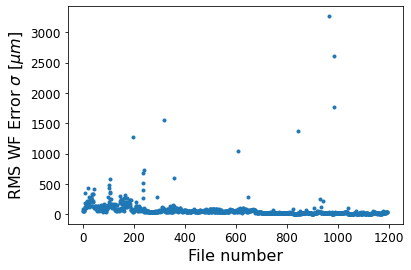

In [9]:
# Standard deviation of RMS Wavefront Errors for each telemetry file
plt.plot(data.rms_std_telemetry, '.')
plt.xlabel("File number")
plt.ylabel(r"RMS WF Error $\sigma$ [$\mu m$]")
plt.show()

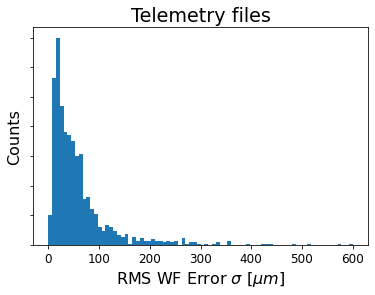

In [10]:
# File histogram
fig, ax = plt.subplots()
ax.hist(data.rms_std_telemetry, bins=80, range=(0, 600), log=False)
ax.set_xlabel(r"RMS WF Error $\sigma$ [$\mu m$]")
ax.set_ylabel("Counts")
ax.set_title("Telemetry files")
ax.set_yticklabels([])
plt.show()

We can see from the plot below that this phenomenon affects two observing nights more strongly than any of the others, as well as the fact that the bad files cover a range of image qualities.

Bad file percentage: 4.93%


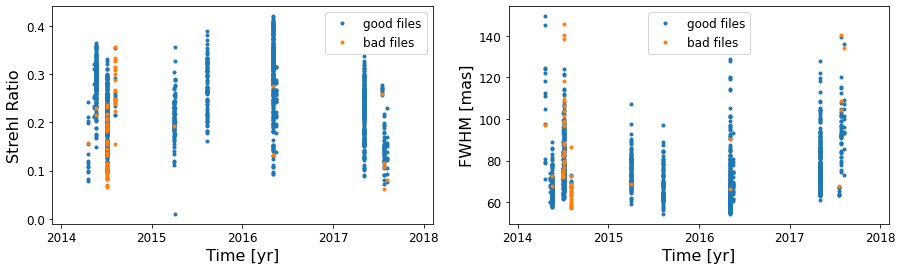

In [11]:
# Filter out bad files
filter_strength = 200 # [EDIT]
bad_files = data[data.rms_std_telemetry > filter_strength]
good_files = data[data.rms_std_telemetry < filter_strength]
print(f"Bad file percentage: {len(bad_files)/len(data)*100:.2f}%")

# Set up plot
fig, ax = plt.subplots(1, 2, figsize=(15,4))
start, end = 2014, 2018.1
years = np.arange(start, end)
xrange = [start-.1, end]

# Plot Strehl
ax[0].plot(good_files.dec_year, good_files.strehl, '.', label='good files')
ax[0].plot(bad_files.dec_year, bad_files.strehl, '.', label='bad files')
ax[0].set_xlim(xrange)
ax[0].set_xticks(years)
ax[0].set_xlabel("Time [yr]")
ax[0].set_ylabel("Strehl Ratio")
ax[0].legend(fontsize=12)

# Plot FWHM
ax[1].plot(good_files.dec_year, good_files.fwhm, '.', label='good files')
ax[1].plot(bad_files.dec_year, bad_files.fwhm, '.', label='bad files')
ax[1].set_xlim(xrange)
ax[1].set_xticks(years)
ax[1].set_xlabel("Time [yr]")
ax[1].set_ylabel("FWHM [mas]")
ax[1].legend(fontsize=12)

plt.show()

### Lenslet plots
We have developed code for plotting lenslet array values from telemetry data, as shown below. Our goal is to use plots like these to investigate the bad telemetry files at the points at which their behavior changes in order to figure out what is happening at a system level. We know that AO system measures the intensity of the sub-apertures and counts the 236 brightest as valid values, so this could factor into our conclusions.

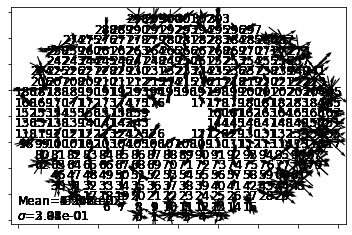

In [12]:
centroids = bad_example.a.offsetcentroid[0]
frames = []
fig, ax = plt.subplots()
for i in range(10):
    im = plot_array(centroids[i,:].reshape([1,-1]), centroid_map, fig=fig, axis=ax, arrows=True)
    frames.append(im)

ani = mpl.animation.ArtistAnimation(fig, frames, interval=50, blit=False,
                                repeat_delay=1000)
plt.show()

RuntimeError: Requested MovieWriter (ffmpeg) not available

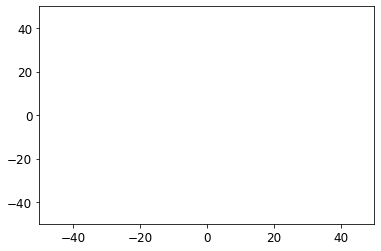